In [1]:
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Importación de qiskit
from qiskit import *

%matplotlib inline
# Importing standard Qiskit libraries
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Protocolo de teleportación cuántica realizado en qiskit


Para este circuito se pretende enviar el estado $|+> = \frac{|0> + |1>}{\sqrt(2)}$ por medio del protocolo de teleportación cuántica. Este código también se puede modificar para enviar cualquier estado que se desee siempre y cuando se trate de $\textbf{un solo qubit}$

La librerías requeridas para poder utilizar este circuito son qiskit y matplotlib.

In [2]:
#Declaración del circuito 
qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
creg_c = ClassicalRegister(3, 'c') #3 registros clásicos
circuit = QuantumCircuit(qreg_q, creg_c) #Se crea un circuito utilizando estos registros

#Instrucciones para el circuito
##Inicialización del estado (por defecto todos los estados en qiskit están en |0>)
# circuit.x(qreg_q[0])
circuit.h(qreg_q[0]) 
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])

#PROTOCOLO DE TELEPORTACIÓN
##Inicialización de estado de Bell: Se inicia el estado beta_00
circuit.h(qreg_q[1]) # Se pone a q1 en superposición
circuit.cx(qreg_q[1], qreg_q[2]) #Se entrelaza con q2 mediante una compuerta not controlada (cx)
circuit.cx(qreg_q[0], qreg_q[1]) #Se entrelaza con q0 (qubit a enviar) mediante la misma operación
circuit.h(qreg_q[0]) #Se pone en superposición este estado resultante

##Continuación del protocolo: Colapsar los estados
# circuit.measure(qreg_q[0], creg_c[0])  #Se hace una medición en q0 y q1 haciendo que sus estados colapsen
# circuit.measure(qreg_q[1], creg_c[1])
circuit.barrier(qreg_q[1], qreg_q[0], qreg_q[2])

##Cierre del protocolo
circuit.cx(qreg_q[1], qreg_q[2]) #Se finaliza el protocolo asignando una compuerta cnot para que q2 ajuste su estado en el momento que q0 y q1 comunican el estado resultante que han obtenido, para que así q2 lo ajuste. 
circuit.cz(qreg_q[0], qreg_q[2]) #Se realiza lo mismo con una cz entra q0 y q1.
# circuit.measure(qreg_q[2],creg_c[2(q)]) #Se hace medición del estado q_2 

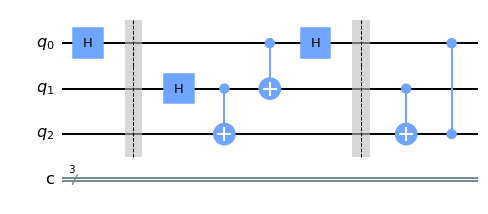

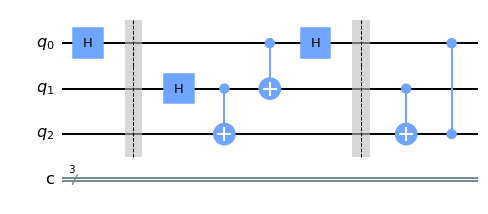

In [3]:
#Se dibuja el circuito 
%matplotlib inline
circuit.draw()

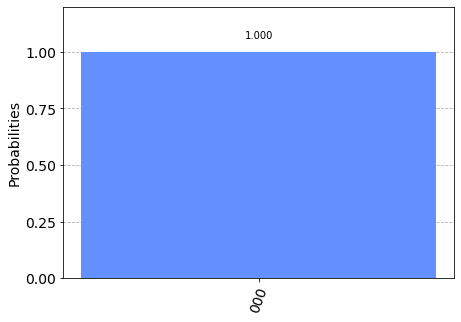

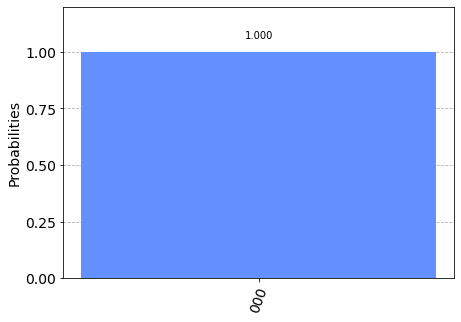

In [4]:
#RESULTADOS SIMULADOS GRACIAS A AER.GET_BACKEND

job = execute(circuit, Aer.get_backend('qasm_simulator'),shots=5000).result() 
# job_monitor(job)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts=job.get_counts(circuit)
plot_histogram(job.get_counts(circuit))

Es importante aclarar que en qiskit el estado colapsado a cada qubit correspondiente sería q0,q1,q2 en la forma en como lo muestra el histograma. Si se mide solamente el estado $|+>$ se tendrían las mismas probabilidades 50/50 en los estados  $|0> $y $|1>$ que es lo aproximadamente apreciado aquí. Sin embargo, si se midiese el estado $|->$ se tendrían exactamente las mismas probabilidades!

$\textbf{Verificación del estado: tomografía de estado cuántico}$

Para darle solución a esto se hace uso de la $\textbf{tomografía cuántica}$ , específicamente de la $\textbf{tomografía de estado cuántico}$ o $\textit{quantum state tomography}$.

La tomografía de estado cuántico nos permite reconstruir la matríz de densidad de un qubit obteniendo sus probabilidades a través de distintas bases. Ya que en este caso se trata de un solo qubit se pasa por las bases correspondientes a las matrices de Pauli: $I,X,Y,Z$.

Qiskit posee funciones que se encargan de realizar este trabajo, por lo que ahora se retira la última medición en q_2 para que se realice la tomografía de estado cuántico y así obtener su matríz de densidad (para esta parte se debe reiniciar el kernel y dejar como comentario la línea con el texto  $\texttt{circuit.measure(qreg_q[2],crec_c[2])}$  ), así como el bloque de resultados.

In [34]:
#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble

# Función para tomografía de estado 
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [6]:
# Se genera el circuito del estado de tomografía
qst_q0 = state_tomography_circuits(circuit, [qreg_q[2]]) #Se llama al circuito de tomografía y se toma el qubit a medir (que en este caso se verá a q2)

#Se manda a ejecutar esta función para su simulación
job = qiskit.execute(qst_q0,Aer.get_backend('qasm_simulator'), shots=5000)

job_monitor(job)

/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/opt/conda/lib/python3.8/site-packages/qiskit/circui

Job Status: job has successfully run


In [7]:
#Se hace un recuento de los estados obtenidos tras los 5000 shots. 
fiteo_tomografia = StateTomographyFitter(job.result(), qst_q0) 
fiteo_tomografia.data #Se muestra la distribución tras pasarlo por cada uno de los operadores

{('X',): {'0': 5000},
 ('Y',): {'0': 2504, '1': 2496},
 ('Z',): {'0': 2440, '1': 2560}}

Aquí es importante aclarar que los estados 0 y 1 $\textbf{no son los mismos en cada base}$, es decir que
$$|0_x> = \frac{1}{\sqrt(2)} (|0_z>+|1_z>)= |+_z> $$
$$|1_x> = \frac{1}{\sqrt(2)} (|0_z>-|1_z>)= |-_z> $$
$$|0_y> = \frac{1}{\sqrt(2)} (|0_z>+|1_z>) $$
$$|1_y> = \frac{1}{\sqrt(2)} (|0_z>-i|1_z>) $$


Con estos resultados se puede reconstruir la matríz de densidad del estado correspondiente a q2, el cual corresponde al estado del receptor. Para esto se usan las funciones correspondientes de qiskit.

In [8]:
# Se hace el ajuste de tomografía  para obtener la matríz de densidad del estado correspondiente a q_2
#Hace este ajsute mediante el método de mínimos cuadrados (o alguno que se seleccione) y lo ajusta hacia
#la variable rho(q_2)
rho_fit_q2 = fiteo_tomografia.fit(method='lstsq') 
print("rho_(q_2)=",rho_fit_q2)

rho_(q_2)= [[0.48800347+0.j         0.49985542-0.00079977j]
 [0.49985542+0.00079977j 0.51199653+0.j        ]]


$\textbf{Reconstrucción de la matríz de densidad de forma manual :} $

Esta reconstrucción está integrada en qiskit como aprte de las funciones de tomografía de estado cuántico. Esto de igual manera se puede hacer de forma manual reescribiendo la matríz de densidad como 
    $$ \rho = \frac{tr(\rho)I + tr(X\rho)X +tr(Y\rho)Y +tr(Z\rho)Z }{2}$$
de donde $tr(A\rho)$ puede tomarse como las medidas del operador $A_i$ realizada un n número de veces $n$ como una aproximación de la forma $tr(A\rho) 	\simeq \sum_i z_i/n$
En estos casos terminan siendo 
$$ tr(\rho) = 1$$
$$ tr(X\rho) = 1 $$
$$ tr(Y\rho) = 0.0044$$
$$ tr(Z\rho) =-0.0096$$

Siendo de esta forma la matríz de densidad escrita como 
  $$ \rho_+ = 
    \begin{pmatrix}
    0.4952 & 0.5-0.0022i\\ 
    0.5+0.0022i & 0.4952
    \end{pmatrix}$$  

En este momento se encuentra que la matríz de densidad respecto al estado en $q_2$ luego de haber pasado por el protocolo de teleportación. En donde esta matríz, coincide con la correspondiente al estado $|+>$

$$ \rho_+ = \frac{1}{2}
\begin{pmatrix}
1 & 1\\ 
1 & 1
\end{pmatrix}$$



La cual es distinta a la que se podría encontrar con el estado $|->$
$$  \rho_- = \frac{1}{2}
\begin{pmatrix}
1 & -1\\ 
-1 & 1
\end{pmatrix}$$

Esta diferencia siempre recae en que los estados $|\pm>$ son autoestados de $X$, por lo que es en esa probabilidad en donde se puede distinguir a cada uno de ellos


Para dar certeza a este proceso tomografico se ve la fidelidad del estado obtenido comparándolo con un estado $|+>$ que no haya sido medido antes. Esto se puede realizar también en qiskit creando otro circuito y realizando la comparación.

In [9]:
#Se crea otro "circuito" en donde se declara un vector análogo a q_0 que vendría siendo el estado +
q2 = QuantumRegister(1, 'q')
q0 = QuantumCircuit(q2)

q0.h(q2[0])
print(q0)

#Se declara a este como el estado objetivo para realizar la comparación con la matríz de densidad obtenida antes
estado_objetivo = qi.Statevector.from_instruction(q0)
print(estado_objetivo)

#Se compara la fidelidad del estado obtenido con el estado correspondiente a q_0 (estado +)
fidelidad_estado = qi.state_fidelity(rho_fit_q2, estado_objetivo)
print('Fidelidad del estado obtenido respecto al inicial q_0: F = {:.5f}'.format(fidelidad_estado))

     ┌───┐
q_0: ┤ H ├
     └───┘
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))
Fidelidad del estado obtenido respecto al inicial q_0: F = 0.99986


Por lo tanto, el qubit q_2 tiene una fidelidad del 99.98% a la del qubit q_0

# Resultados experimentales

A continuación se muestra el mismo circuito ejecutado en una de las computadoras cuánticas de IBM (ibmq_athens)

In [3]:
# Cargando cuenta de IBM (para realizar esto es necesaria una cuenta de IBM, preferiblemente esta sección se peude cargar desde IBM quantum lab)
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_santiago') #En este caso se corre en la computadora ibm santiago 

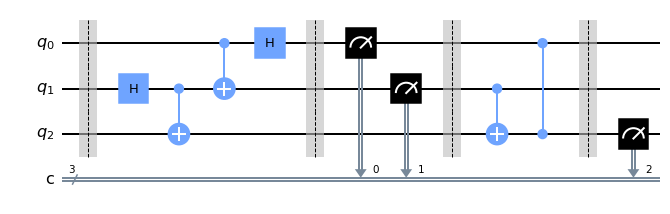

In [4]:
#EL CIRCUITO SE VUELVE A DECLARAR EN CASO DE QUE HAYA ALGÚN ERROR O SE QUIERA TRABAJAR DE OTRA FORMA, DE IGUAL MANERA SE PUEDE CREAR
#OTRO CIRCUITO CON LA MISMA CONFIGURACIÓN

#Declaración del circuito 

qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
creg_c = ClassicalRegister(3, 'c') #3 registros clásicos
circuit = QuantumCircuit(qreg_q, creg_c) #Se crea un circuito utilizando estos registros

#Instrucciones para el circuito
##Inicialización del estado (por defecto todos los estados en qiskit están en |0>)
# circuit.h(qreg_q[0]) 
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2])

#PROTOCOLO DE TELEPORTACIÓN
##Inicialización de estado de Bell: Se inicia el estado beta_00
circuit.h(qreg_q[1]) # Se pone a q1 en superposición
circuit.cx(qreg_q[1], qreg_q[2]) #Se entrelaza con q2 mediante una compuerta not controlada (cx)
circuit.cx(qreg_q[0], qreg_q[1]) #Se entrelaza con q0 (qubit a enviar) mediante la misma operación
circuit.h(qreg_q[0]) #Se pone en superposición este estado resultante

##Continuación del protocolo: Colapsar los estados
circuit.barrier(qreg_q[1], qreg_q[0], qreg_q[2])
circuit.measure(qreg_q[0], creg_c[0])  #Se hace una medición en q0 y q1 haciendo que sus estados colapsen
circuit.measure(qreg_q[1], creg_c[1])
circuit.barrier(qreg_q[1], qreg_q[0], qreg_q[2])

##Cierre del protocolo
circuit.cx(qreg_q[1], qreg_q[2]) #Se finaliza el protocolo asignando una compuerta cnot para que q2 ajuste su estado en el momento que q0 y q1 comunican el estado resultante que han obtenido, para que así q2 lo ajuste. 
circuit.cz(qreg_q[0], qreg_q[2]) #Se realiza lo mismo con una cz entra q0 y q1.
circuit.barrier(qreg_q[0],qreg_q[1],qreg_q[2])
circuit.measure(qreg_q[2],creg_c[2]) #Se hace medición del estado q_2 

# circuit.measure(qreg_q[2], creg_c[2])
circuit.draw()

In [ ]:
# #RESULTADOS experimentaless, realizados en la computadora cuántica seleccionada
job = execute(circuit, backend=qcomp)
job_monitor(job)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts=job.result().get_counts(circuit)
plot_histogram(job.result().get_counts(circuit))

Job Status: job is queued (1253)  

In [41]:
#Proceso de tomografía siendo ejecutado de forma experiemtal en una computadora cuántica 

#Ojo, para esto siempre dejar como comentario la línea circuit.measure(qreg_q[2],creg_c[2]) 
#en el circuito y ejecutar ese bloque.


qst_q0 = state_tomography_circuits(circuit, [qreg_q[2]])

#Se manda a ejecutar esta función para su simulación
job = qiskit.execute(qst_q0,backend=qcomp, shots=5000)

job_monitor(job)
#Se hace un ajuste del resultado en comparación del estado otorgado al inicio


fiteo_tomografia = StateTomographyFitter(job.result(), qst_q0) 

fiteo_tomografia.data #Se muestra la distribución tras pasarlo por cada uno de los operadores
# Se hace el ajuste de tomografía  para obtener la matríz de densidad de la misma
rho_fit_q2 = fiteo_tomografia.fit(method='lstsq')
print("rho_(q_2)=",rho_fit_q2)

#Se crea otro "circuito" en donde se declara un vector análogo a q_0 que vendría siendo el estado +
q2 = QuantumRegister(1, 'q')
q0 = QuantumCircuit(q2)

# q0.h(q2[0])
print(q0)
print("")
#Se declara a este como el estado objetivo para realizar la comparación con la matríz de densidad obtenida antes
estado_objetivo = qi.Statevector.from_instruction(q0)
print(estado_objetivo)
print("")

#Se compara la fidelidad del estado obtenido con el estado correspondiente a q_0 (estado +)
fidelidad_estado = qi.state_fidelity(rho_fit_q2, estado_objetivo)
print('Fidelidad del estado obtenido respecto al inicial q_0: F = {:.5f}'.format(fidelidad_estado))

Job Status: job has successfully run
rho_(q_2)= [[0.7214+0.j     0.0106+0.0126j]
 [0.0106-0.0126j 0.2786+0.j    ]]
     
q_0: 
     

Statevector([1.+0.j, 0.+0.j],
            dims=(2,))

Fidelidad del estado obtenido respecto al inicial q_0: F = 0.72140


Por lo tanto, el circuito presentado cumple con el protocolo de teleportación. Sin embargo, experimentalmente las computadoras cuánticas necesitan ser refinadas para dar con resultados acordes a las simulaciones. Esto puede deberse a ruido o imperfecciones en el equipo las cuales deben ser ajustadas en este código para su uso experimental 


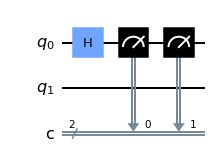

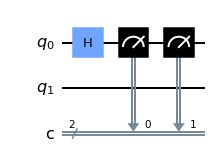

In [19]:
circuit2= QuantumCircuit(2,2)
circuit2.h(0)
circuit2.measure(0,0)
circuit2.measure(0,1)
circuit2.draw()

Job Status: job has successfully run


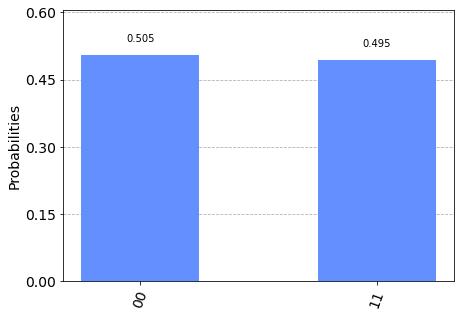

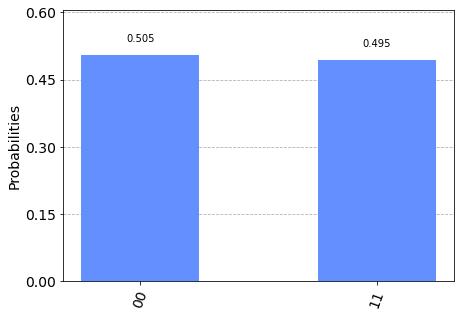

In [70]:
#RESULTADOS SIMULADOS GRACIAS A AER.GET_BACKEND

job = qiskit.execute(circuit2, Aer.get_backend('qasm_simulator'),shots=5000) 
job_monitor(job)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts=job.result().get_counts(circuit2)
plot_histogram(job.result().get_counts(circuit2))

Job Status: job has successfully run


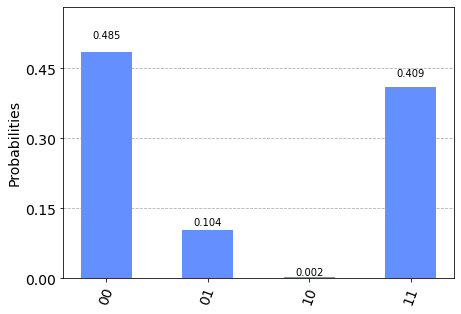

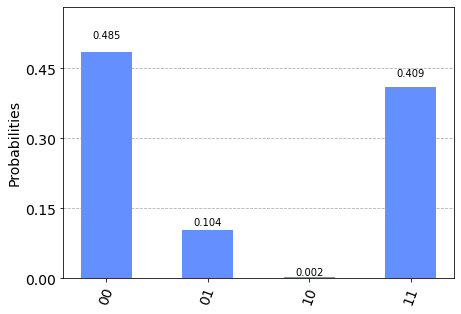

In [75]:
# #RESULTADOS experimentaless, realizados en la computadora cuántica seleccionada
job = execute(circuit2, backend=qcomp, shots=5000)
job_monitor(job)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts=job.result().get_counts(circuit2)
plot_histogram(job.result().get_counts(circuit2))

In [76]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [100]:
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')

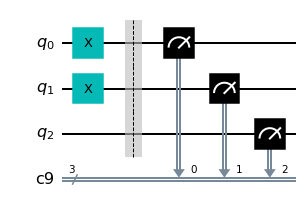

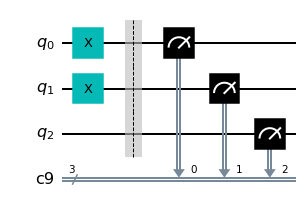

In [101]:
cal_circuits[3].draw()

In [102]:
cal_job = execute(cal_circuits,
             backend=qcomp,
             shots=5000,
             optimization_level=0)
#print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


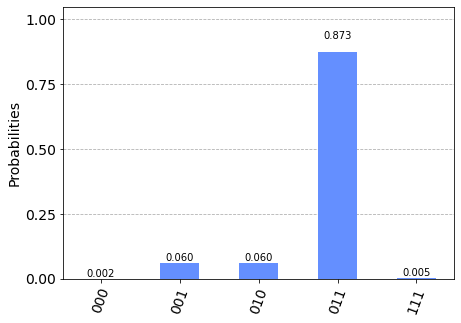

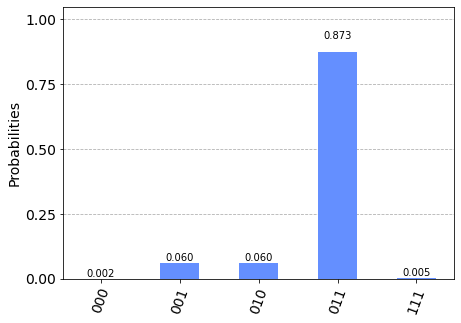

In [104]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [105]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

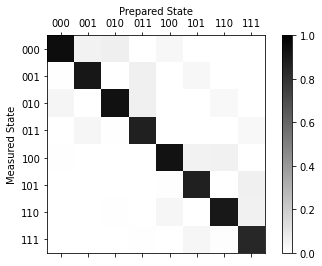

In [106]:
meas_fitter.plot_calibration()

In [107]:
meas_filter = meas_fitter.filter

In [108]:
mitigated_result = meas_filter.apply(job.result())

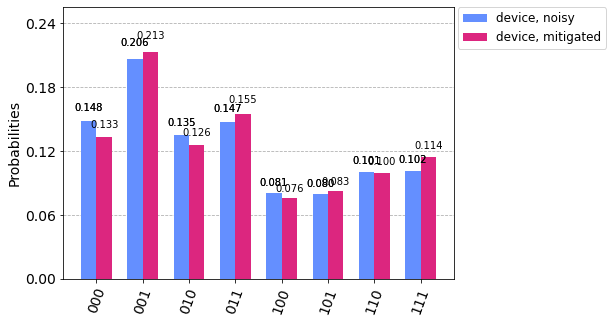

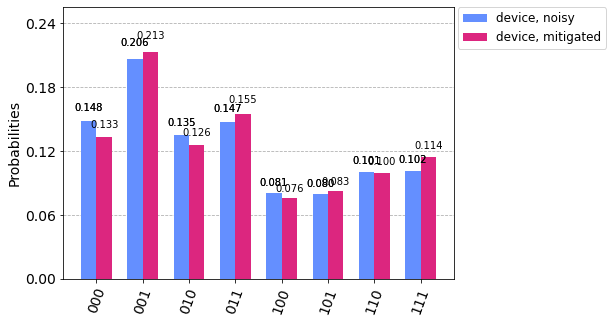

In [109]:
device_counts = job.result().get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

Protocolo de teleportación para el estado generado


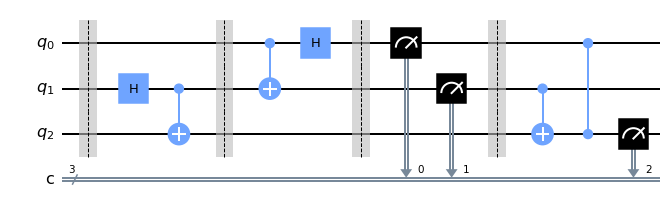

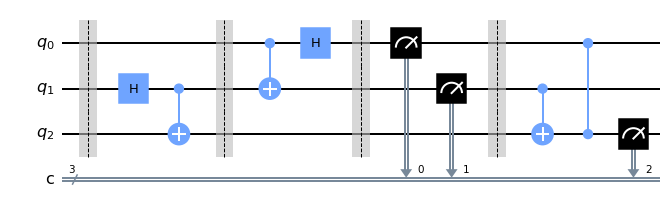

In [66]:
                                        """ Generación del estado aleatorio y circuito  """

# estado_inicial.initialize(a,q_0) #Se inicializa el estado aleatorio que se almacenó en a hacia el circuito inicial para comparar
 
#     """ Proceso de teleportación del estado aleatorio conseguido """

qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos
creg_c = ClassicalRegister(3, 'c') #3 registros clásicos
circuit = QuantumCircuit(qreg_q, creg_c) #Se crea un circuito utilizando estos registros
a= [-0.65749907-0.13548217j, -0.61206004+0.41799768j]
a= a/np.linalg.norm(a)
#Instrucciones para el circuito
##Inicialización del estado (por defecto todos los estados en qiskit están en |0>)

# circuit.initialize(a,qreg_q[0])   #Se inicializa en el circuito de teleportación el estado aleatorio almacenado 
# circuit.x(qreg_q[0])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 

#PROTOCOLO DE TELEPORTACIÓN
##Inicialización de estado de Bell: Se inicia el estado beta_00
circuit.h(qreg_q[1]) # Se pone a q1 en superposición
circuit.cx(qreg_q[1], qreg_q[2]) #Se entrelaza con q2 mediante una compuerta not controlada (cx)
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
circuit.cx(qreg_q[0], qreg_q[1]) #Se entrelaza con q0 (qubit a enviar) mediante la misma operación
circuit.h(qreg_q[0]) #Se pone en superposición este estado resultante
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
circuit.measure(qreg_q[0], creg_c[0])  #Se hace una medición en q0 y q1 haciendo que sus estados colapsen
circuit.measure(qreg_q[1], creg_c[1])
circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2]) 
##Continuación del protocolo: Colapsar los estados
##Cierre del protocolo
circuit.cx(qreg_q[1], qreg_q[2]) #Se finaliza el protocolo asignando una compuerta cnot para que q2 ajuste su estado en el momento que q0 y q1 comunican el estado resultante que han obtenido, para que así q2 lo ajuste. 
circuit.cz(qreg_q[0], qreg_q[2]) #Se realiza lo mismo con una cz entra q0 y q1.
circuit.measure(qreg_q[2],creg_c[2]) #Se hace medición del estado q_2 
print("Protocolo de teleportación para el estado generado")
circuit.draw()

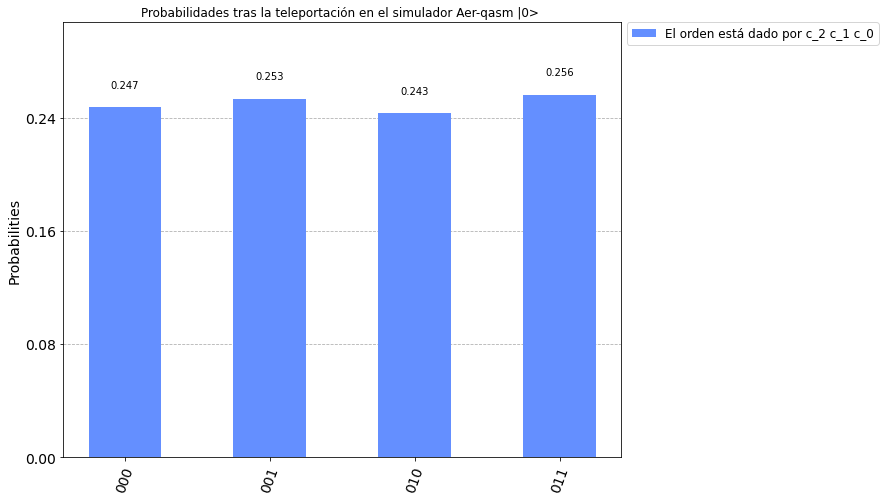

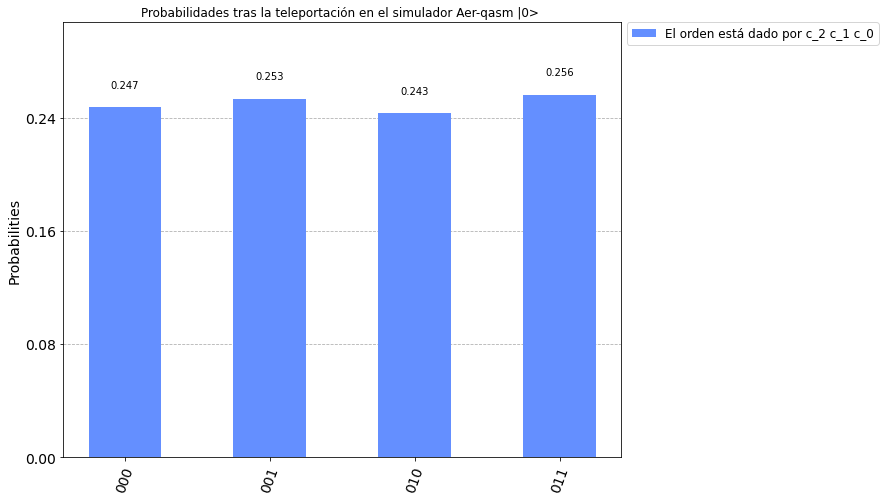

In [69]:
#RESULTADOS SIMULADOS GRACIAS A AER.GET_BACKEND

job_simu = execute(circuit, Aer.get_backend('qasm_simulator'),shots=5000).result() 
# job_monitor(job)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts_simu=job_simu.get_counts(circuit)
plot_histogram(counts_simu,title='Probabilidades tras la teleportación en el simulador Aer-qasm |0> ',legend=['El orden está dado por c_2 c_1 c_0'],figsize=(10,8))

ibmqfactory.load_account:WARNING:2021-09-02 06:38:23,613: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


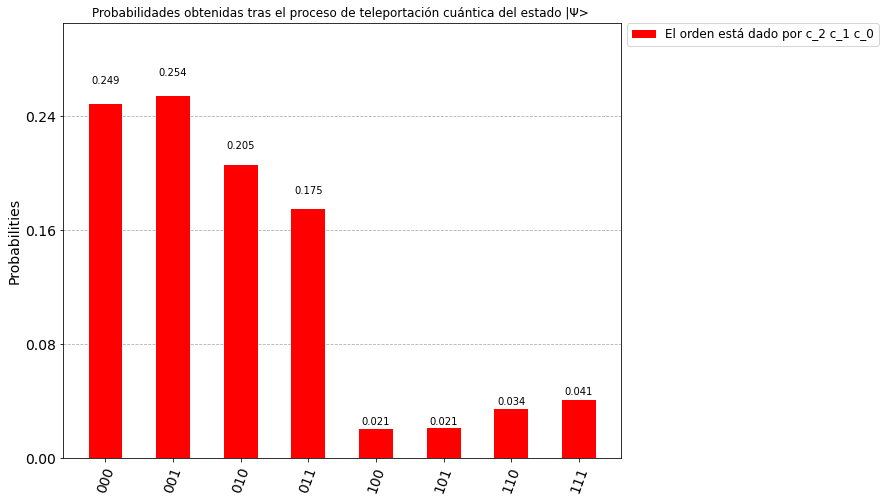

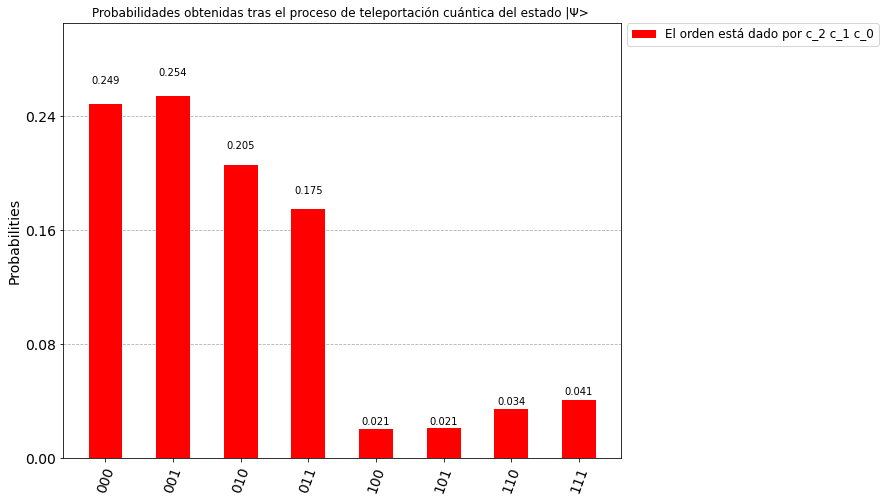

In [68]:
#RESULTADOS SIMULADOS GRACIAS A AER.GET_BACKEND
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibmq_belem') #En este caso se corre en la computadora

job_qcomp = execute(circuit, backend=qcomp,shots=5000)
job_monitor(job_qcomp)
#Se muestra a manera de histograma los resultados obtenidos tras ejecutar este circuito en un número considerable de ocasiones
from qiskit.tools.visualization import plot_histogram
counts=job_qcomp.result().get_counts(circuit)
plot_histogram(counts,title='Probabilidades obtenidas tras el proceso de teleportación cuántica del estado |0> ',color='red',legend=['El orden está dado por c_2 c_1 c_0'],figsize=(10,8))

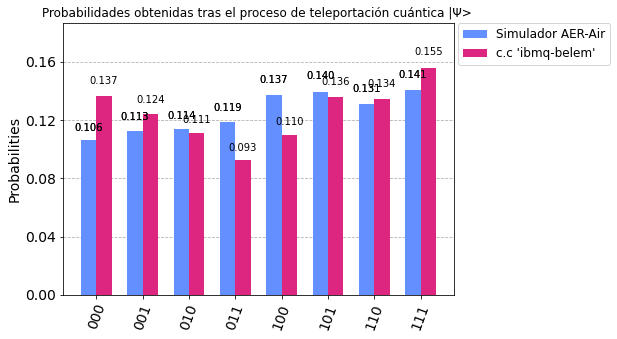

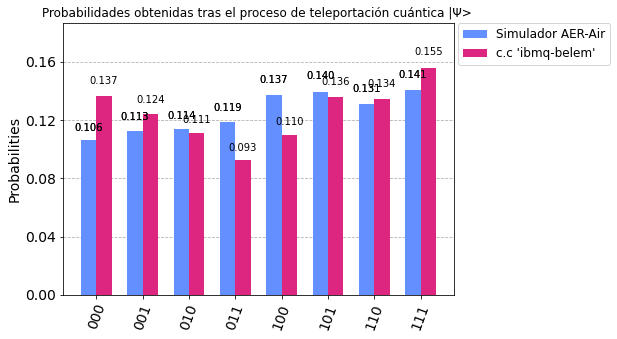

In [58]:
plot_histogram([counts_simu, counts], 
               legend=['Simulador AER-Air', "c.c 'ibmq-belem'" ],title='Probabilidades obtenidas tras el proceso de teleportación cuántica |Ψ> ')